In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                              
from tqdm import tqdm
import pandas as pd

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
model = tf.keras.models.load_model('Intel_Court_Model.h5py')

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [5]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['test_Intel']
    output = []
    
    # Iterate through training and test sets

        
    images = []
    labels = []
        
    print("Loading {}".format(datasets[0]))
        
        # Iterate through each folder corresponding to a category
    for folder in os.listdir(datasets[0]):
          label = class_names_label[folder]
            
            # Iterate through each image in our folder
          for file in tqdm(os.listdir(os.path.join(datasets[0], folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(datasets[0], folder), file)
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')   
        
    output.append((images, labels))

    return images,labels

In [6]:
test_images, test_labels = load_data()

Loading test_Intel


100%|██████████| 4/4 [00:00<00:00, 2004.93it/s]


In [7]:
n_test = test_labels.shape[0]

print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of testing examples: 24
Each image is of size: (150, 150)


Scale The Data :

In [8]:
test_images = test_images / 255.0

In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

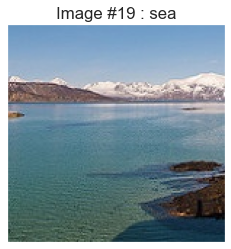

In [10]:
display_random_image(class_names, test_images, test_labels)

In [11]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]

activation_models=models.Model(inputs=model.input,outputs=layer_outputs)
activations = activation_models.predict(test_images,verbose=0)

pred_labels=np.argmax(activations[6],axis=1) 

In [12]:
pred_labels

array([3, 3, 3, 1, 3, 5, 5, 5, 2, 2, 4, 4, 0, 0, 0, 2, 4, 4, 4, 4, 1, 1,
       1, 1], dtype=int64)

In [13]:
def display_examples(class_names, images, labels,numClass):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(numClass):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [14]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels,len(mislabeled_labels))
    

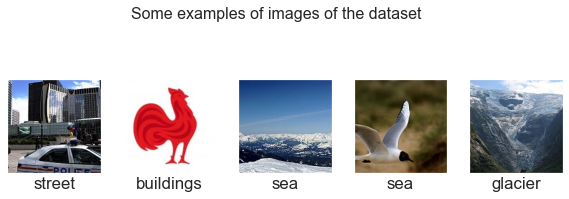

In [15]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

In [16]:
test_layers=[]
for i in range(len(activations)):
  test_layers.append(activations[i])


In [17]:
test_layers[6].shape

(24, 6)

In [18]:
import keras
import skimage.io 
import skimage.segmentation
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
%matplotlib inline
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [19]:
len(test_labels)

24

In [22]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    test_images[4].astype('double'), 
    model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

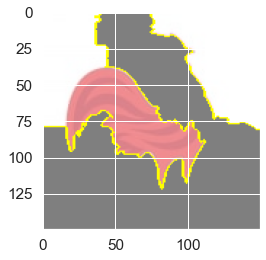

In [23]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True)
plt.imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask));
image=plt.imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask));

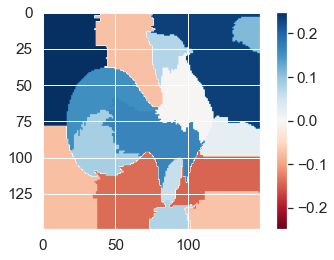

In [24]:
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max());
plt.colorbar();